### Import Libraries

In [67]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [68]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [69]:
# Import some other useful libraries or functions
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import keras_cv.layers as kcvl
from sklearn.decomposition import PCA
from scipy.spatial import distance
from sklearn.manifold import TSNE

In [81]:
# Check if the notebook is running on Kaggle or locally
import os
onKaggle = False
if ('PWD'in os.environ):
    onKaggle = True
print(onKaggle)


In [ ]:
TL_EPOCHS = 500
FT_EPOCHS = 500
useCutMixAndMixUp = True

# Other parameters
data_folder = "data/public_data.npz"
if onKaggle:
    data_folder = '/kaggle/input/an2dl-ch1-data/public_data.npz'
val_split = 0.1
input_shape = (96, 96, 3)

### Data Exploration

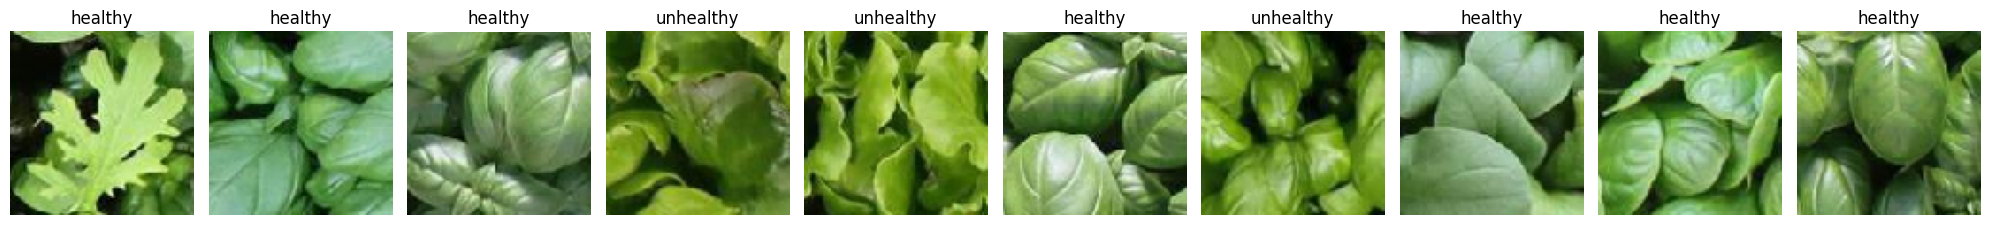

In [82]:
data = np.load(data_folder,allow_pickle=True)
images = data[data.files[0]]
labels = data[data.files[1]]
# Convert to int
images = images.astype(int)
# Plot first 10 images
_ , axes = plt.subplots(1,10, figsize = (20,8))
axes = axes.reshape((-1,))
for i in range(10):
    axes[i].imshow(np.clip(images[i],0,255))
    axes[i].axis('off')
    axes[i].set_title(labels[i])

plt.tight_layout()
# plt.savefig('public.png')

### PCA

Percentage of variance explained by the principal components: [0.10320786 0.06540438]


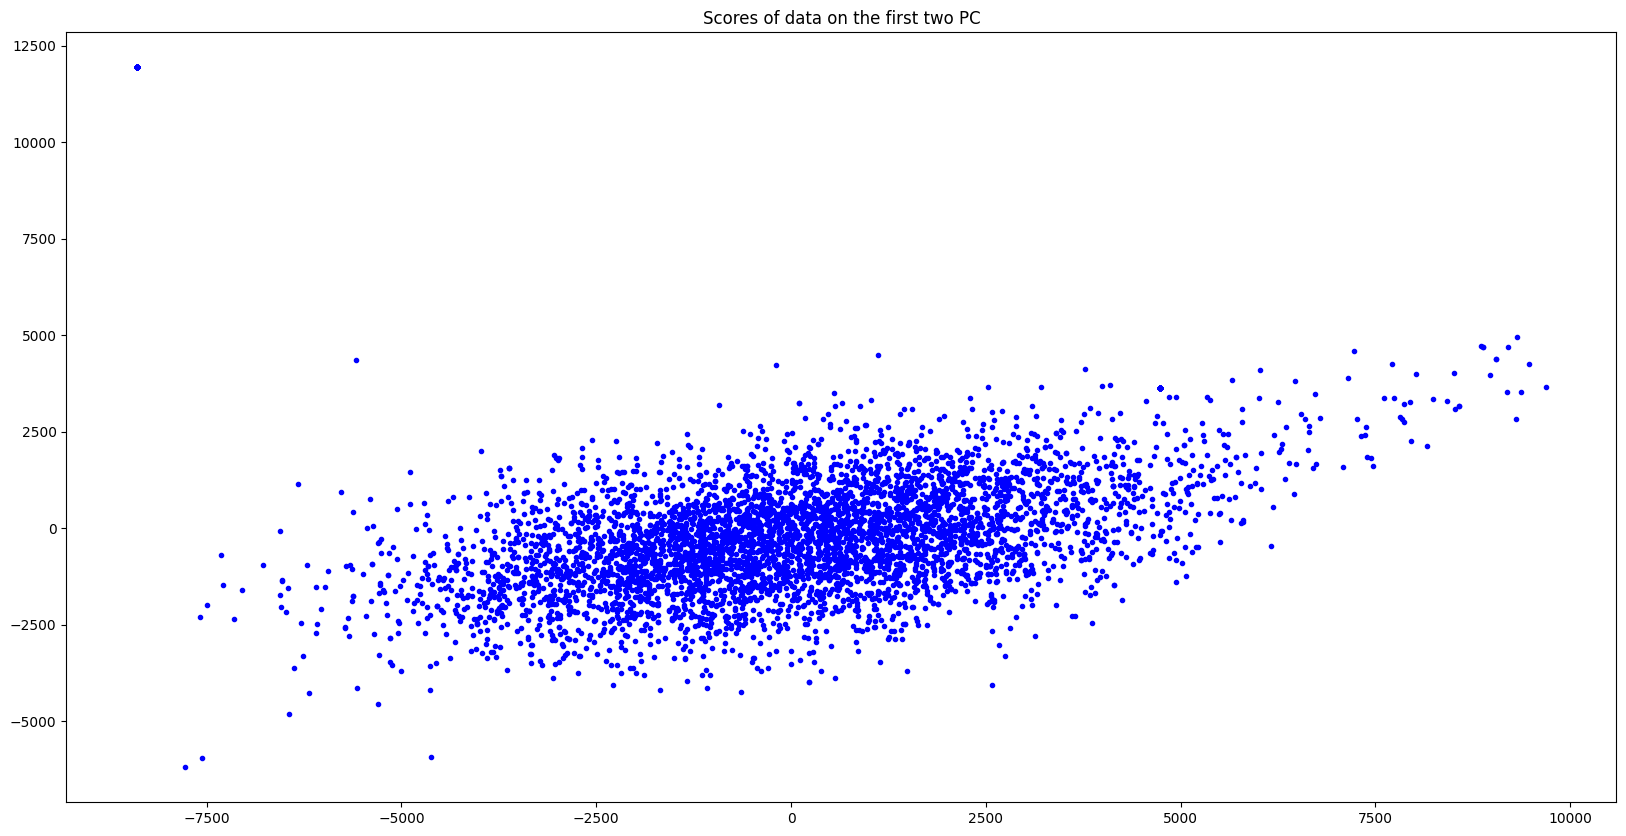

In [72]:
# Dimensional reduction with PCA for anomaly detection
images_flat = images.reshape((len(images),3*96*96))
pca = PCA(n_components=2)
pca.fit(images_flat)
print("Percentage of variance explained by the principal components:",pca.explained_variance_ratio_)
scores = pca.transform(images_flat)

plt.figure(figsize=[20,10])
plt.title('Scores of data on the first two PC')
plt.plot(scores[:,0],scores[:,1], 'b.')
plt.show()

2


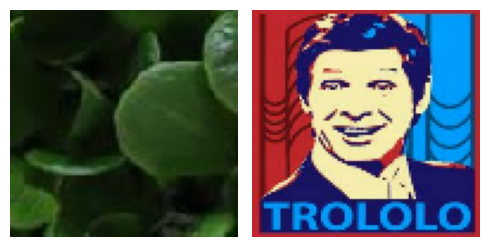

In [73]:
# Compute the mahalanobis distance for scores of the two first PCs to find possible outliers
mahalanobis_distances = [distance.mahalanobis(x, np.mean(scores,axis=0), np.linalg.inv(np.cov(scores.T))) for x in scores]
out = np.where(np.array(mahalanobis_distances) >=4)[0]

uniq = np.unique(images[out],axis=0)

#Plot the outliers
fig , axes = plt.subplots(1,len(uniq), figsize = (5,5))
print(len(uniq))
axes = axes.reshape((-1,))
for i in range(len(uniq)):
    axes[i].imshow(np.clip(uniq[i],0,255))
    axes[i].axis('off')
plt.tight_layout()

### t_SNE

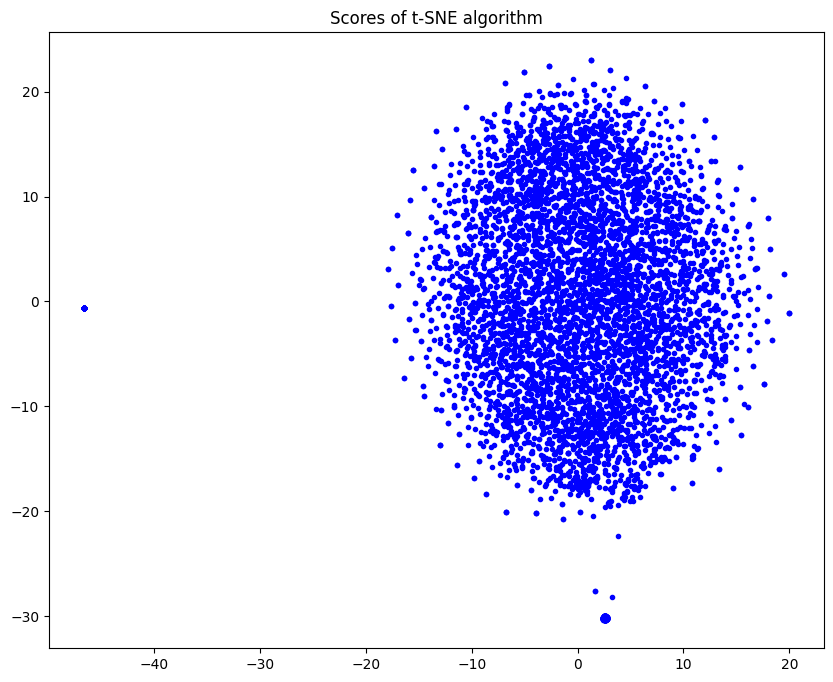

In [74]:
# Dimensional reduction with t-SNE for anomaly detection
scores_tsne = TSNE(n_components=2,perplexity=60,learning_rate="auto").fit_transform(images_flat)

plt.figure(figsize=[10,8])
plt.title('Scores of t-SNE algorithm')
plt.plot(scores_tsne[:,0],scores_tsne[:,1], 'b.')
plt.show()

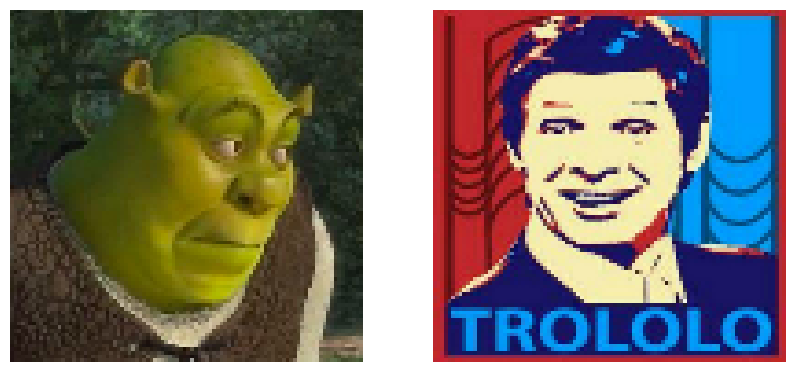

In [75]:
# Plot outliers
out = np.where(scores_tsne[:,1]<(-30))[0]
out = np.concatenate([out,np.where(scores_tsne[:,0]<(-40))[0]])
uniq = np.unique(images[out],axis=0)
_ , axes = plt.subplots(1,len(uniq), figsize = (10,5))
axes = axes.reshape((-1,))
for i in range(len(uniq)):
    axes[i].imshow(np.clip(uniq[i],0,255))
    axes[i].axis('off')

# Competition code

### Create train,validation and test sets

In [76]:
# Remove memes and doubles
def clean_data(x, y):
     # Remove memes
    trololo = np.all(x == x[338], axis=(1, 2, 3))
    shrek = np.all(x == x[58], axis=(1, 2, 3))
    memes = (shrek | trololo)
    images = x[~memes]
    labels = y[~memes]

    # Remove doubles
    _, uniqueIds = np.unique(images, return_index= True, axis=0)
    images = images[uniqueIds]
    labels = labels[uniqueIds]
    return images, labels

# Extract data from the npz file, if train is True also clean the data
def extract_data(file_name,train = False):
    data_folder = f"data/{file_name}.npz"
    if onKaggle:
        data_folder = f'/kaggle/input/an2dl-ch1-data/{file_name}.npz'
    data = np.load(data_folder,allow_pickle=True)
    lst = data.files
    X = data[lst[0]]
    y = data[lst[1]]

    if train:
        X, y = clean_data(X, y)

    # Convert values in data to int
    X = X.astype(int)
    # Normalize data to the range [0, 1]
    X_t = (X / 255).astype('float32')

    # Create a mapping from label string to values
    map = {'healthy':0 , 'unhealthy':1}

    # Map labels from string to the corresponding encoding
    int_labels = np.array([map[label] for label in y])

    # Convert labels to categorical format using one-hot encoding
    y_t = tfk.utils.to_categorical(int_labels)
    return X_t,y_t

In [77]:
X_train_val,y_train_val = extract_data("public_data",True)
X_test_private,y_test_private = extract_data("private_test") # Not available during challenge but added for completeness
X_test_public,y_test_public = extract_data("public_test") # Not available during challenge but added for completeness

# Split public data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=val_split, stratify=y_train_val)
del X_train_val, y_train_val

### Augment data with CutMix and MixUp

In [78]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples[0]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0])
        plt.axis("off")
    plt.show()

In [79]:
BATCH_SIZE = 16 # 4365 images / 16 = 272 batches

# Create a tf.data.Dataset from the training set
base_train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .cache()
                 .shuffle(BATCH_SIZE * 100,reshuffle_each_iteration=True,seed=seed)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.experimental.AUTOTUNE)
                 )

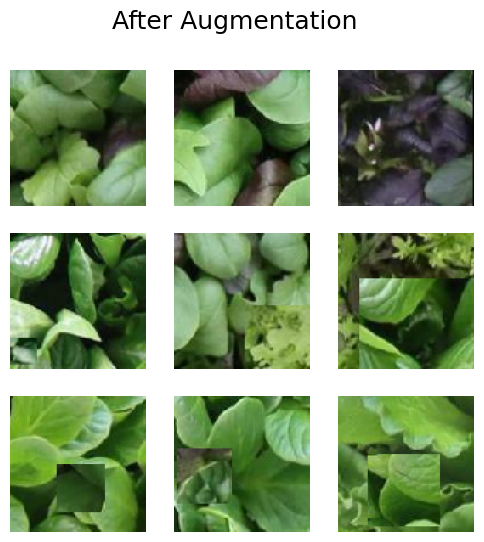

In [80]:
def to_dict(img, label):
    return {"images": img, "labels": label}


def prep_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    return images, labels


# N:B keras_cv expect target to be one hot encoded
def cutmix_or_mixup(samples):
    # half of the images are augmented with cutmix and remaining with mixup
    if tf.random.uniform((),seed=seed) > 0.5:
        samples = kcvl.CutMix(seed=seed)(samples)
    else:
        samples = kcvl.MixUp(seed=seed)(samples)
    return samples

if(useCutMixAndMixUp):
    train_dataset = base_train_dataset.map(to_dict).map(cutmix_or_mixup).map(prep_for_model)
else:
    train_dataset = base_train_dataset
visualize_dataset(train_dataset, title="After Augmentation")

### Define the Model

In [11]:
base_name = "convnext_xlarge"
tl_name = f"{base_name}_tl"
ft_name = f"{base_name}_ft"
# Use ConvNeXtXLarge as a base model for transfer learning.
base_model = tf.keras.applications.ConvNeXtXLarge(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
)

# Freeze the weights to preserve pre-trained knowledge.
base_model.trainable = False

1393257616/1393257616 [==============================] - 6s 0us/step


In [12]:
# Define an image augmentation pipeline including
# - RandAugment (https://arxiv.org/abs/1909.13719),
# - RandomFlip (horizontal and vertical),
# - RandomZoom,
# - RandomRotation.

augmentation_layer = tf.keras.Sequential(
    [
    kcvl.RandAugment(
        # parameters set as in the paper
        value_range = (0,1),
        augmentations_per_image=3,
        magnitude=0.3,
        magnitude_stddev=0.15,
        rate=0.9090909090909091,
        geometric=True,
        seed=seed,
        ),
    tfkl.RandomFlip(),
    tfkl.RandomRotation(factor= 0.5),],
    name="augmentation_layer",)

In [13]:
# Override the train_step() in model class to augment data only during training and not for final evaluation.
 
class CustomModel(tfk.Model):
    def train_step(self, data):
        x, y, sample_weight = tf.keras.utils.unpack_x_y_sample_weight(data)

        # Perform augmentation on the input data for training
        x = augmentation_layer(x, training= True)

        # Run forward pass.
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss = self.compute_loss(x, y, y_pred, sample_weight)
        self._validate_target_and_loss(y, loss)
        # Run backwards pass.
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
        return self.compute_metrics(x, y, y_pred, sample_weight)

    def compile(self, *args, **kwargs):
        super(CustomModel, self).compile(*args, **kwargs, metrics=['accuracy'])

In [14]:
def build_complete_model(input_shape=(96, 96, 3)):
    """
        Build a ConvNeXtLarge-based CNN with image augmentation, and a custom
        classifier for binary classification of healthy and unhealthy leaves.
    """
    tf.random.set_seed(seed)
    inputs = tfk.Input(shape=input_shape)

    # Cast input
    augmented_255 = tf.cast(inputs* 255, tf.uint8)

    x1 = base_model(augmented_255)
    x2 = tfkl.GlobalAveragePooling2D(name="avg_pool")(x1)
    norm = tfkl.BatchNormalization(name="batch_normalization")(x2)

    # Add a Dense layer with 2 units and softmax activation as the classifier
    intermediate1 = tfkl.Dense(1024, activation=tf.keras.activations.swish)(norm)

    outputs = tfkl.Dense(2, activation='softmax')(intermediate1)

    # Create a Model connecting input and output
    model = CustomModel(inputs=inputs, outputs=outputs, name='model')

    # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
    optimizer = tf.keras.optimizers.AdamW()
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=optimizer)

    # Return the model
    return model

### Define some utility functions for training

In [15]:
# Plot model loss and accuracy
def plot_history(history):
    acc = history["accuracy"]
    val_acc = history["val_accuracy"]

    loss = history["loss"]
    val_loss = history["val_loss"]

    plt.figure(figsize=(20, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Accuracy")

    plt.subplot(2, 1, 2)
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Loss")
    plt.show()

# Evaluate model on training,valiation and test sets
def evaluate_model(model):
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    train_loss, train_accuracy = model.evaluate(train_dataset)
    public_test_loss, public_test_accuracy = model.evaluate(X_test_public, y_test_public)
    private_test_loss, private_test_accuracy = model.evaluate(X_test_private, y_test_private)

    # Display the evaluation metrics for the model
    print("Model evaluation:")
    print("Train loss:", train_loss)
    print("Train accuracy:", train_accuracy)
    print("Validation loss:", val_loss)
    print("Validation accuracy:", val_accuracy)
    print("Public Test loss:", public_test_loss)
    print("Public Test accuracy:", public_test_accuracy)
    print("Private Test loss:", private_test_loss)
    print("Private Test accuracy:", private_test_accuracy)

## Transfer Learning

In [16]:
es_callback = tfk.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=50,
    restore_best_weights=True,
)

reduce_lr_callback = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=10,
    factor=0.5,
    mode="max",
    min_lr=1e-8,
)

In [17]:
# Build a ConvNeXtLarge model for transfer learning
tl_model = build_complete_model()

# Train the model with transfer learning
tl_history = tl_model.fit(
    train_dataset,
    batch_size = BATCH_SIZE,
    epochs = TL_EPOCHS,
    validation_data = (X_val, y_val), # validation data
    callbacks = [es_callback,reduce_lr_callback,]
).history

Epoch 1/500


I0000 00:00:1708515415.241206      64 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


273/273 [==============================] - 103s 236ms/step - loss: 0.9749 - accuracy: 0.6733 - val_loss: 0.5879 - val_accuracy: 0.7155 - lr: 0.0010
Epoch 2/500
273/273 [==============================] - 51s 187ms/step - loss: 0.5964 - accuracy: 0.7148 - val_loss: 0.5110 - val_accuracy: 0.7670 - lr: 0.0010
Epoch 3/500
273/273 [==============================] - 50s 182ms/step - loss: 0.6048 - accuracy: 0.7015 - val_loss: 0.4738 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 4/500
273/273 [==============================] - 51s 187ms/step - loss: 0.5793 - accuracy: 0.7136 - val_loss: 0.4080 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 5/500
273/273 [==============================] - 50s 182ms/step - loss: 0.5785 - accuracy: 0.7111 - val_loss: 0.3947 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 6/500
273/273 [==============================] - 50s 183ms/step - loss: 0.5669 - accuracy: 0.7315 - val_loss: 0.5018 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 7/500
273/273 [==============================] - 50

In [18]:
# Save model and history
np.save('tl_history', tl_history)
tl_model.save(tl_name)
print(f"Finished training of {tl_name}. Model saved successfully.")

Finished training of convnext_xlarge_tl. Model saved successfully.


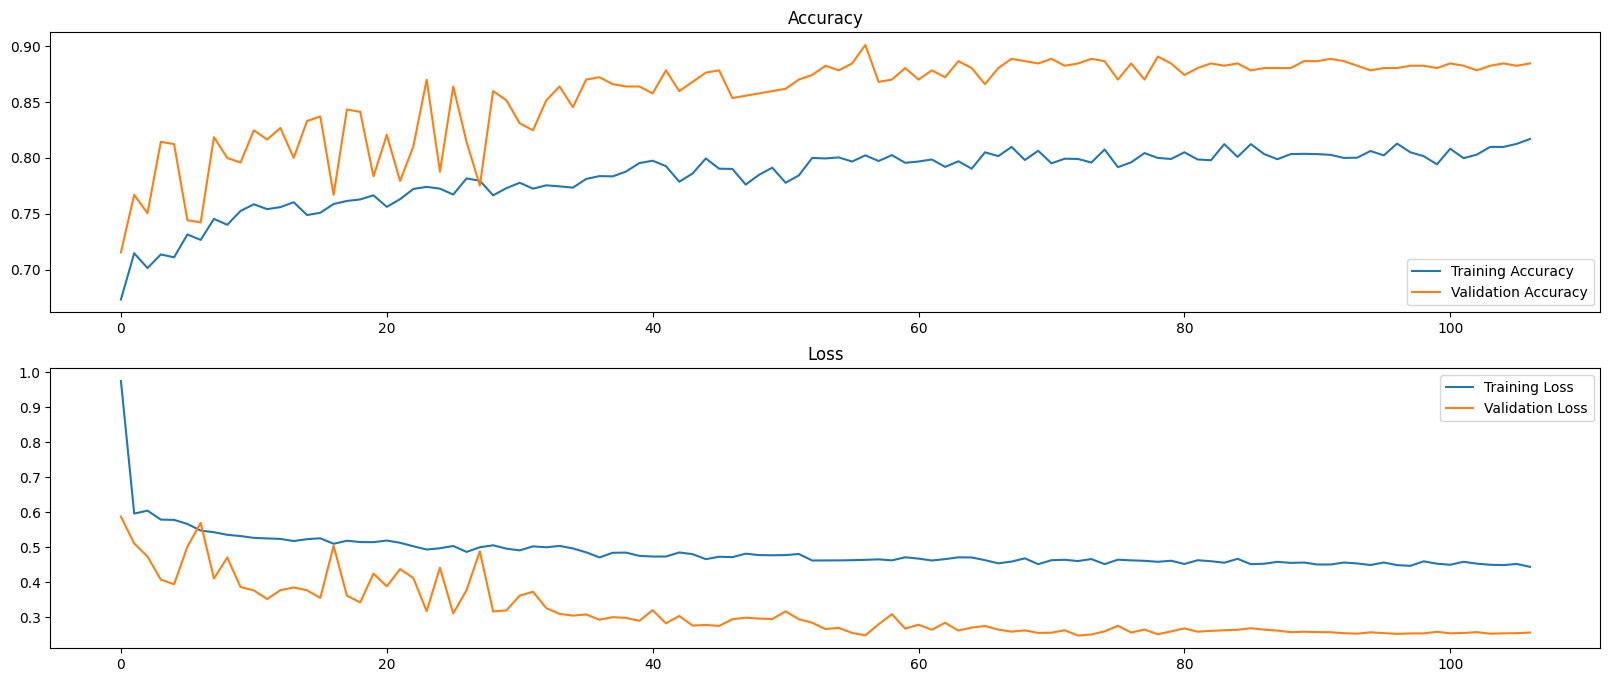

In [19]:
plot_history(tl_history)

In [20]:
evaluate_model(tl_model)

32/32 [==============================] - 9s 279ms/step - loss: 0.3205 - accuracy: 0.8570
Model evaluation:
Train loss: 0.4153144061565399
Train accuracy: 0.8348224759101868
Validation loss: 0.24889129400253296
Validation accuracy: 0.9010308980941772
Public Test loss: 0.2841207683086395
Public Test accuracy: 0.9100000262260437
Private Test loss: 0.32048413157463074
Private Test accuracy: 0.8569999933242798


# Fine Tuning

In [21]:
# Save weights of the Transfer Learning model
tl_model.save_weights(f'{tl_name}_weights')

In [22]:
# Create a new instance of CustomModel for fine-tuning
ft_model = build_complete_model()

# Load the weights for the model
ft_model.load_weights(f'{tl_name}_weights')

In [23]:
# Set all layers as trainable
ft_model.trainable = True

if all(layer.trainable for layer in ft_model.layers):
    print("Successful!")
else:
    print("Error!")

ft_model.get_layer('batch_normalization').trainable = False

Successful!


In [24]:
# Display the summary of the Transfer Learning model
ft_model.summary()

# Display the layers and their trainable status within the base model
print(f"Layers within '{base_name}' submodule:")
for i, layer in enumerate(ft_model.get_layer(base_name).layers):
    print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 tf.math.multiply_1 (TFOpLa  (None, 96, 96, 3)         0         
 mbda)                                                           
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 96, 96, 3)         0         
                                                                 
 convnext_xlarge (Functiona  (None, 3, 3, 2048)        348147968 
 l)                                                              
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                             

In [25]:
# Freeze the first N layers of the base model. Train the rest and the fully-connected part.
N = 149 # Half of the layers
for i, layer in enumerate(ft_model.get_layer(base_name).layers[:N]):
    layer.trainable = False

# Display the layers and their updated trainable status within the submodule
print("Updated trainable status after freezing layers:")
for i, layer in enumerate(ft_model.get_layer(base_name).layers):
    print(i, layer.name, layer.trainable)

Updated trainable status after freezing layers:
0 input_1 False
1 convnext_xlarge_prestem_normalization False
2 convnext_xlarge_stem False
3 convnext_xlarge_stage_0_block_0_depthwise_conv False
4 convnext_xlarge_stage_0_block_0_layernorm False
5 convnext_xlarge_stage_0_block_0_pointwise_conv_1 False
6 convnext_xlarge_stage_0_block_0_gelu False
7 convnext_xlarge_stage_0_block_0_pointwise_conv_2 False
8 convnext_xlarge_stage_0_block_0_layer_scale False
9 convnext_xlarge_stage_0_block_0_identity False
10 tf.__operators__.add False
11 convnext_xlarge_stage_0_block_1_depthwise_conv False
12 convnext_xlarge_stage_0_block_1_layernorm False
13 convnext_xlarge_stage_0_block_1_pointwise_conv_1 False
14 convnext_xlarge_stage_0_block_1_gelu False
15 convnext_xlarge_stage_0_block_1_pointwise_conv_2 False
16 convnext_xlarge_stage_0_block_1_layer_scale False
17 convnext_xlarge_stage_0_block_1_identity False
18 tf.__operators__.add_1 False
19 convnext_xlarge_stage_0_block_2_depthwise_conv False
20 con

In [26]:
# Compile the Transfer Learning model
ft_model.compile(
    loss=tfk.losses.CategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate=5e-5,# Lower learning rate
                                   weight_decay= 0.01,# Increase weight decay to avoid overfitting
                                   ))

In [27]:
es_callback = tfk.callbacks.EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    patience=40,
    restore_best_weights=True,
)

reduce_lr_callback = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    patience=10,
    factor=0.5,
    mode="max",
    min_lr=1e-8,
)

In [28]:
# Train the model with fine-tuning
ft_history = ft_model.fit(
    train_dataset,
    batch_size = BATCH_SIZE,
    epochs = FT_EPOCHS,
    validation_data = (X_val, y_val),
    callbacks = [es_callback,reduce_lr_callback]
).history

Epoch 1/500
273/273 [==============================] - 139s 335ms/step - loss: 0.4543 - accuracy: 0.8046 - val_loss: 0.2520 - val_accuracy: 0.9010 - lr: 5.0000e-05
Epoch 2/500
273/273 [==============================] - 82s 301ms/step - loss: 0.4571 - accuracy: 0.8016 - val_loss: 0.2355 - val_accuracy: 0.8948 - lr: 5.0000e-05
Epoch 3/500
273/273 [==============================] - 83s 304ms/step - loss: 0.4520 - accuracy: 0.8076 - val_loss: 0.2402 - val_accuracy: 0.9052 - lr: 5.0000e-05
Epoch 4/500
273/273 [==============================] - 82s 302ms/step - loss: 0.4356 - accuracy: 0.8192 - val_loss: 0.2259 - val_accuracy: 0.8969 - lr: 5.0000e-05
Epoch 5/500
273/273 [==============================] - 82s 302ms/step - loss: 0.4359 - accuracy: 0.8197 - val_loss: 0.2464 - val_accuracy: 0.8948 - lr: 5.0000e-05
Epoch 6/500
273/273 [==============================] - 83s 302ms/step - loss: 0.4271 - accuracy: 0.8236 - val_loss: 0.2449 - val_accuracy: 0.8990 - lr: 5.0000e-05
Epoch 7/500
273/273 [

In [29]:
# Save model and history
np.save('ft_history', ft_history)
ft_model.save(ft_name)
print(f"Finished training of {ft_name}. Model saved successfully.")

Finished training of convnext_xlarge_ft. Model saved successfully.


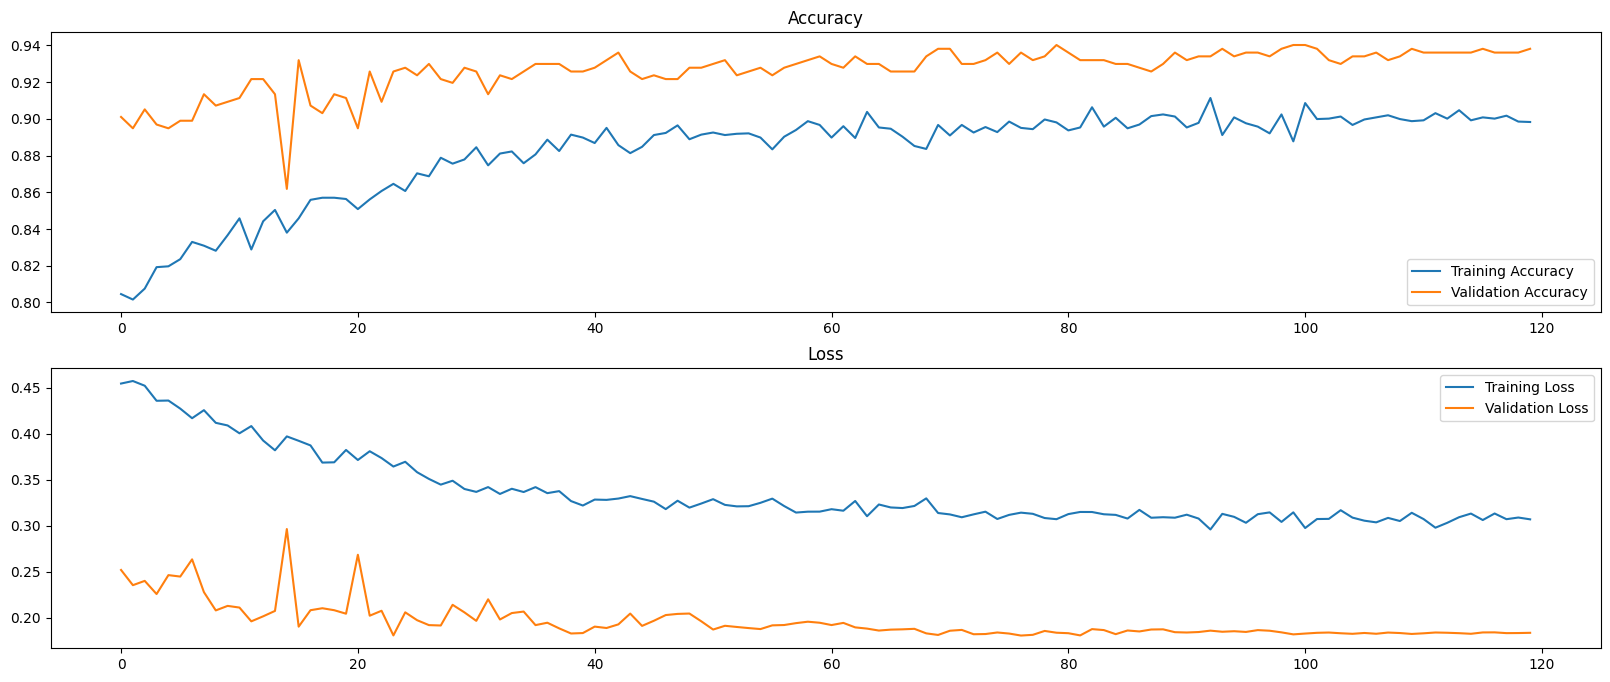

In [30]:
plot_history(ft_history)

In [31]:
evaluate_model(ft_model)

32/32 [==============================] - 6s 191ms/step - loss: 0.2180 - accuracy: 0.9110
Model evaluation:
Train loss: 0.30173709988594055
Train accuracy: 0.9170675873756409
Validation loss: 0.1839229315519333
Validation accuracy: 0.9402061700820923
Public Test loss: 0.20777355134487152
Public Test accuracy: 0.9300000071525574
Private Test loss: 0.21803578734397888
Private Test accuracy: 0.9110000133514404
